# MOFAcellular - Multicellular Factor Analysis

## Background

In [Ramirez et al, 2023](https://europepmc.org/article/ppr/ppr620471), we recently showed a repurposed use of the statistical framework of multi-omics factor analysis ([MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124)) and [MOFA+](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1) to analyse cross-condition single-cell atlases. Specifically, we represented the cross-conditional (e.g. healthy vs. diseased) single-cell transcriptomics data as a multi-view structure, where each cell type represents an individual view that contains summarized information per sample (e.g. pseudobulk). We then applied MOFA to estimate a latent space that captures the variability of the data across samples and cell types.

In this tutorial, we will guide the generation of a multi-view structure from single-cell transcriptomics data and a basic application of MOFA to capture multicellular variability. We make use of the [MuData](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html)/[muon](https://link.springer.com/article/10.1186/s13059-021-02577-8) infrastructure. 

## Load Packages

mofa, decoupler, omnipath, and marsilea can be installed via pip with the following commands:

```python
pip install "decoupler>=2.0.0"
pip install mofax
pip install muon
pip install omnipath
pip install marsilea
```

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

import decoupler as dc

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load & Prep Data

As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

This dataset is downloaded from a link on Figshare; preprocessed for [pertpy](https://github.com/theislab/pertpy).

In [2]:
adata = li.testing.datasets.kang_2018()

100%|██████████| 36.6M/36.6M [00:05<00:00, 6.70MB/s]
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/testing/datasets.py:36: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


In [3]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [4]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_abbr'

### Basic QC

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [5]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
# Store the counts to use them later
adata.layers["counts"] = adata.X.copy()

# Normalize and find marker genes per cell type
# We will use those to remove potential noise from the data  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby=groupby)

... storing 'sample' as categorical


### Showcase the data

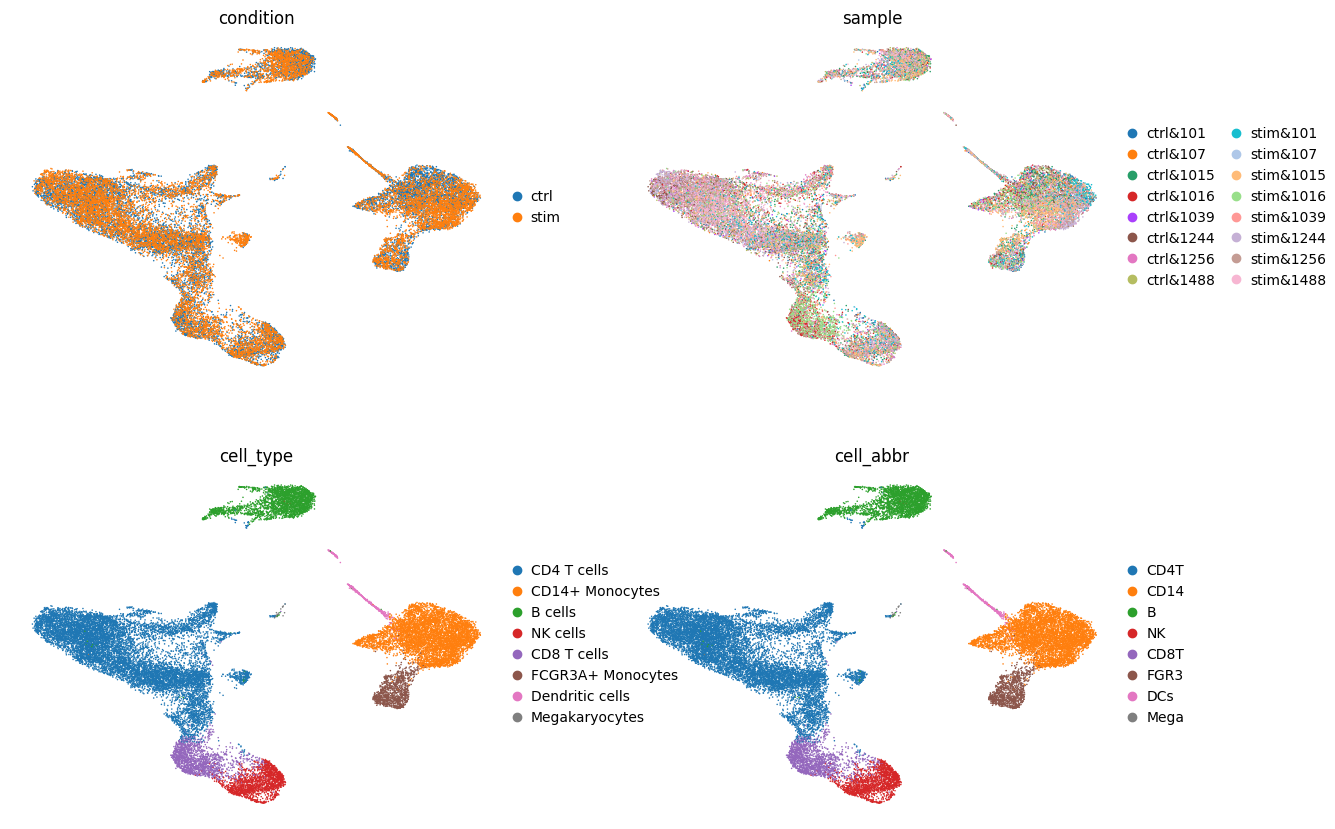

In [7]:
# Show pre-computed UMAP
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

## Create a Multi-View Structure

To construct a multi-view structure, we need to define the views. In this case, we will use the `adata_to_views` function from liana to create a list of views (stored in a MuData object), where each view corresponds to a cell type.
Simply put, we summarize the samples to pseudobulks by cell type, and then we create a view for each cell type. 

We refer users to decoupler's `get_pseudobulk` function for more information about filtering and aggregation options.

In [9]:
mdata = li.multi.adata_to_views(adata,
                                groupby=groupby,
                                sample_key=sample_key,
                                keep_stats=True,
                                obs_keys=['condition', 'patient'], # add those to mdata.obs
                                psbulk_kwargs= {'layer': 'counts', 'verbose': False},
                                filter_samples_kwargs={'min_cells': 25, 'min_counts': 100}, # filter samples
                                filter_by_expr_kwargs={'min_count': 10, 'min_total_count': 15, 'large_n': 5}, 
                                filter_by_prop_kwargs={'min_prop': 0.05, 'min_smpls': 3}, # filter features
                                )

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


We see that we have 7 modalities (views) that correspond to the sufficiently abundant cell types & genes in the data.

We can also explore the statistics at the pseodobulk level, when `keep_stats=True`:

In [10]:
mdata.uns['psbulk_stats'].head()

,CD14:psbulk_counts,CD4T:psbulk_counts,DCs:psbulk_counts,NK:psbulk_counts,CD8T:psbulk_counts,B:psbulk_counts,FGR3:psbulk_counts
ctrl&1016,742765.0,528665.0,88298.0,79082.0,457417.0,152335.0,208274.0
ctrl&1256,1007854.0,1274913.0,129281.0,213089.0,107109.0,260261.0,143636.0
ctrl&1015,1793578.0,1113616.0,146189.0,177960.0,94175.0,556570.0,438020.0
ctrl&1488,562885.0,1415836.0,160656.0,102821.0,32339.0,290329.0,188376.0
ctrl&101,531210.0,403847.0,95330.0,57550.0,27892.0,124446.0,197588.0


## Pre-process the pseudobulk profiles

(Optional) Let's remove what one would consider background marker genes.
The intuition here is that marker genes from some cell types should not be deregulated across conditions in others, and thus, they should not be captured by the latent space.

In [11]:
# create dictionary of markers for each cell type
markers = {}
top_n = 25
for cell_type in mdata.mod.keys():
    markers[cell_type] = (sc.get.rank_genes_groups_df(adata, group=cell_type).
                          sort_values("scores", key=abs, ascending=False).
                          head(top_n)['names'].
                          tolist()
                          )

In [12]:
li.multi.filter_view_markers(mdata, markers=markers, var_column=None, inplace=True)
mdata.update()

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudat

Next, we will normalize each of the views independently to ensure that samples are comparable.
We will also identify the highly-variable genes per view (i.e. across samples) - this is optional & dependent on our assumptions.

In [13]:
for view in mdata.mod.keys():
    
    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.log1p(mdata.mod[view])
    
    sc.pp.highly_variable_genes(mdata.mod[view])

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a vie

We will use the `filter_view_markers` to remove genes that are considered background.

We suggest users to also consider internal `muon` functions (e.g. `mu.pp.filter_obs` & `mu.pp.filter_var`) to remove cells and variables that are not informative.

<div class="alert alert-info">

**Note**

<h5> View Representation </h5>

MOFA supports the flexible representation of views, where each view can represent a different type of features (e.g. genes, proteins, metabolites, etc.). In this case, we simply allow for different genes to be used in each view.

</div>  

## Fitting a MOFA model

Now that the single-cell data is transformed into a multi-view representation, we can use MOFA to run a multicellular factor analysis.

We will attempt to capture the variability across samples and the different cell-types by reducing the data into a number of factors, where each factor captures the coordinated gene expression across cell types.

In [15]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           n_factors=5,
           seed=1337,
           outfile='models/mofacellx.h5ad',
           use_var='highly_variable'
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CD14' group='group1' with N=16 samples and D=2661 features...
Loaded view='CD4T' group='group1' with N=16 samples and D=2769 features...
Loaded view='DCs' group='group1' with N=16 samples and D=866 features...
Loaded view='NK' group='group1' with N=16 samples and D=808 features...
Loaded view='CD8T' group='group1' with N=16 samples and D=486 features...
Loaded view=

## Exploring the MOFA model

For convenience, we provide simple getter function to access the model parameters, in addition to those available via the [MuData API](https://mudata.readthedocs.io/en/latest/api/index.html) & the MOFA model itself.

### Explore Metadata Associations to the Factor Scores

In [16]:
adata = sc.AnnData(obs = mdata.obs, obsm=mdata.obsm)

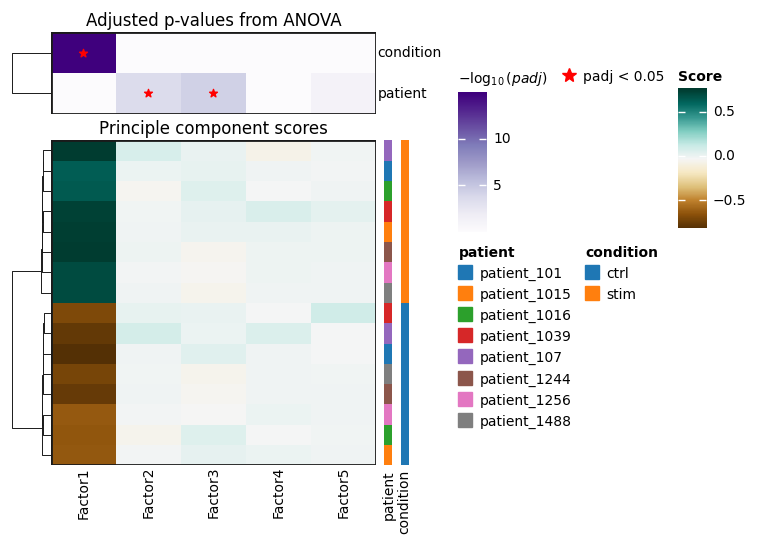

In [17]:
dc.tl.rankby_obsm(
    adata,
    key='X_mofa',  # Where the PCs are stored
    uns_key='rank_obsm',  # Where the results are stored
)

dc.pl.obsm(
    adata,
    key='rank_obsm',
    names = ['patient', 'condition'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    nvar=10,
)

In [18]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=['condition', 'patient'])
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,condition,patient
0,ctrl&1016,-0.632848,-0.052638,0.051865,-0.024249,-0.013498,ctrl,patient_1016
1,ctrl&1256,-0.619726,-0.017901,-0.028237,0.005292,-0.003111,ctrl,patient_1256
2,ctrl&1015,-0.627621,-0.016091,0.027082,0.003699,-0.004085,ctrl,patient_1015
3,ctrl&1488,-0.706452,-0.014176,-0.051899,-0.003661,-0.009408,ctrl,patient_1488
4,ctrl&101,-0.808617,-0.003630,0.042131,-0.003391,-0.025985,ctrl,patient_101


Let's check if any of the factors are associated with the sample condition:

In [19]:
 # we use a paired t-test as the samples are paired
from scipy.stats import ttest_rel

In [20]:
# split in control and stimulated
group1 = factor_scores[factor_scores['condition']=='ctrl']
group2 = factor_scores[factor_scores['condition']=='stim']

# get all columns that contain factor & loop
factors = [col for col in factor_scores.columns if 'Factor' in col]
for factor in factors:
    print(ttest_rel(group1[factor], group2[factor]))
    

TtestResult(statistic=-36.70525735749615, pvalue=2.8951763758879776e-09, df=7)
TtestResult(statistic=-0.10486959132354771, pvalue=0.9194209594623384, df=7)
TtestResult(statistic=0.24427008991619806, pvalue=0.8140268352756767, df=7)
TtestResult(statistic=0.14908407553469905, pvalue=0.8856914836182672, df=7)
TtestResult(statistic=0.37162448579080765, pvalue=0.7211660767570934, df=7)


We can see that the first factor is associated with the sample condition, let's plot the factor scores:

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


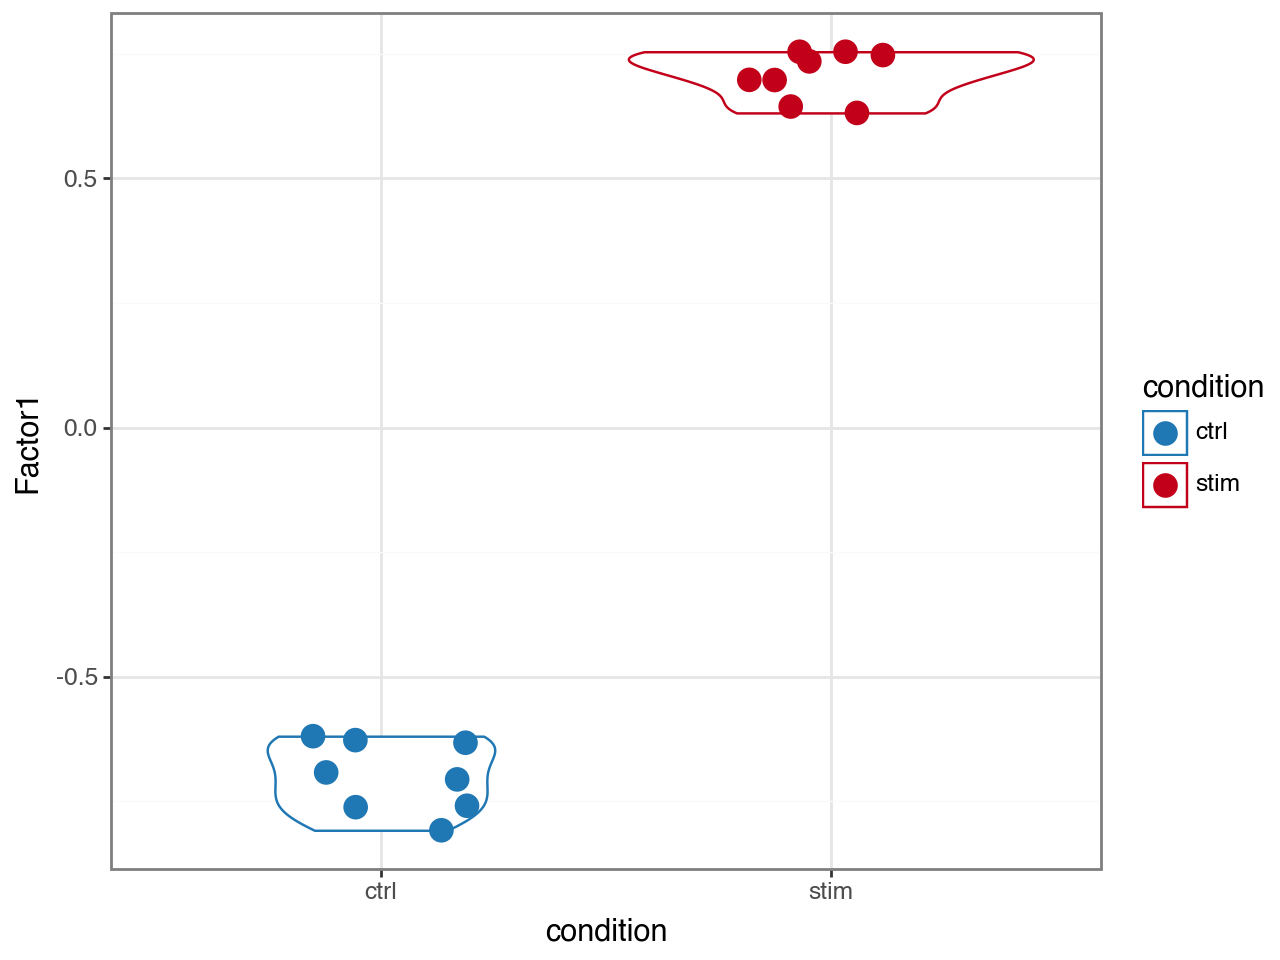

In [21]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw() +
 p9.scale_colour_manual(values=['#1f77b4', '#c20019'])
 )

#### Explore Feature loadings

Now that we have identified a factor that is associated with the sample condition, we can check the features with the highest loadings associated with each cell type:

In [22]:
variable_loadings =  li.ut.get_variable_loadings(mdata, varm_key='LFs', view_sep=':') # get loadings
# order features by absolute value for Factor 1
variable_loadings = variable_loadings.sort_values(by='Factor1', key=lambda x: abs(x), ascending=False)
variable_loadings.head()

,view,variable,Factor1,Factor2,Factor3,Factor4,Factor5
52,CD14,IFIT3,2.531078,-0.237797,0.457865,-0.513977,0.377910
2204,CD14,TNFSF10,2.482870,-0.512341,0.192037,-0.173462,-0.138376
2352,CD14,RSAD2,2.473428,-0.076946,0.264261,-0.186039,0.052113
8075,B,ISG15,2.387439,-0.256105,0.225821,-0.431430,2.381114
733,CD14,IDO1,2.137254,-0.826152,-0.102399,-0.047606,-0.145235


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


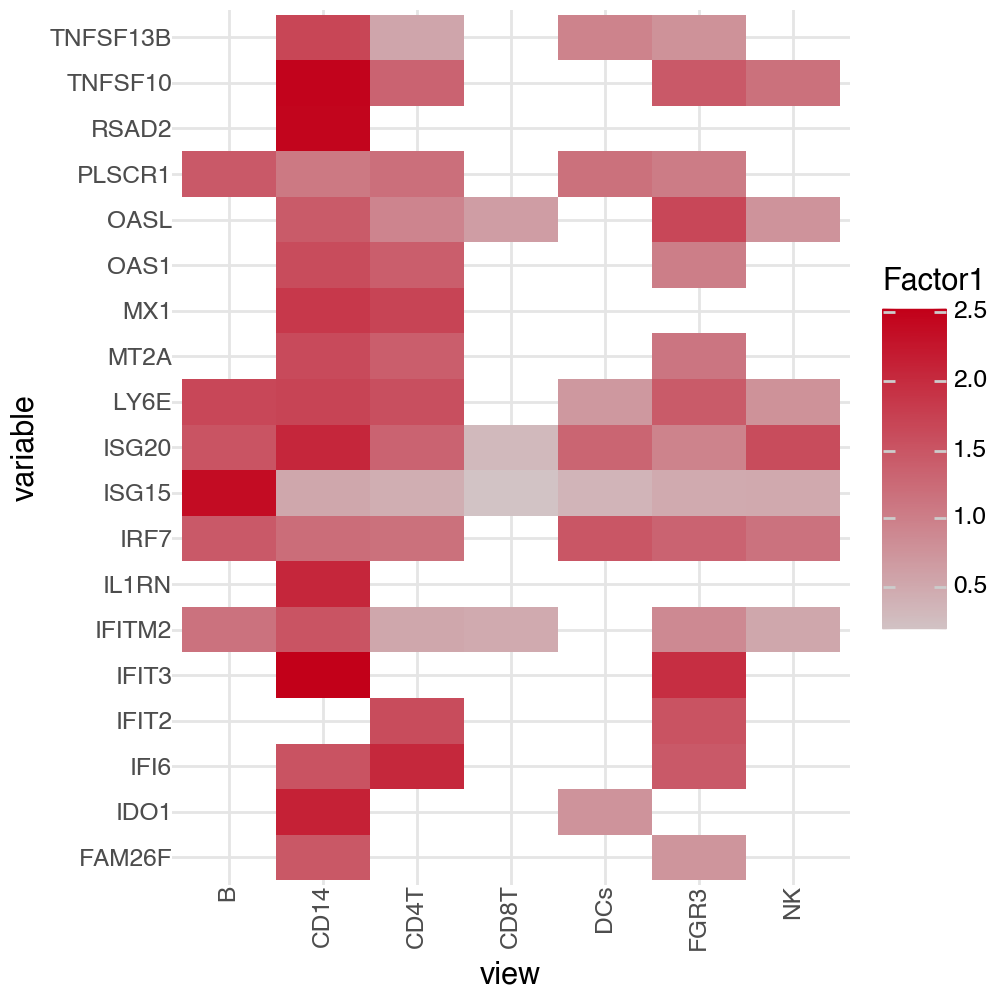

In [23]:
# get top genes with highest absolute loadings across all views
top_genes = variable_loadings['variable'].head(30)
top_loadings = variable_loadings[variable_loadings['variable'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

# plot them
# dotplot of variable, view, loadings
(p9.ggplot(top_loadings) + 
 p9.aes(x='view', y='variable', fill='Factor1') + 
 p9.geom_tile() +
 p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') + 
 p9.theme_minimal() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5), figure_size=(5, 5))
 )

We can see that some genes are present in only some of the cell type views and that some of the genes with highest (absolute) loadings tend to be cell type specific. Many genes are also be shared across views, but it's challenging to to decipher if they are shared because they are coordinated by the same biological process or because of technical issues with the data.
Thus, an essential step in the analysis is to select the genes for each cell type (view) in a way that is consistent with the biological knowledge of those cell types.

**NB: the interpretation of the sign of the feature loadings is relevant only to the sign of the factor scores themselves. In other words, a negative sign would mean that the features are negatively associated with the scores of a given factor, and the contrary for positive loadings!**

### Explore the model

Finally, we can also explore the MOFA model itself and we will specifically check the variance explained by each cell type.

In [27]:
model = mofa.mofa_model("models/mofacellx.h5ad")
model

MOFA+ model: mofacellx.h5ad
Samples (cells): 16
Features: 9997
Groups: group1 (16)
Views: B (1235), CD14 (2661), CD4T (2769), CD8T (486), DCs (866), FGR3 (1172), NK (808)
Factors: 5
Expectations: W, Z

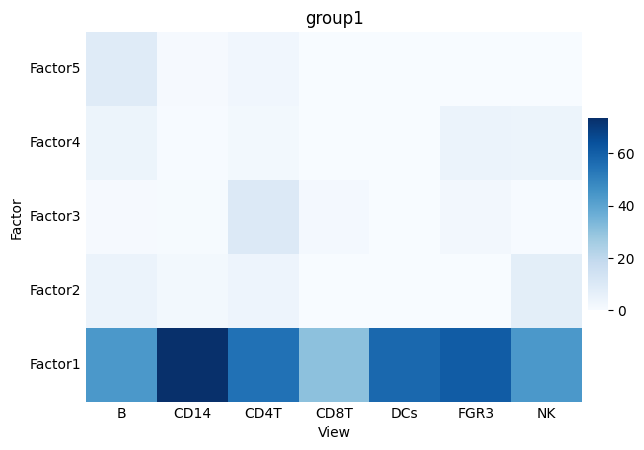

In [28]:
mofa.plot_r2(model, x='View')

We can see that Factor 1 captures the majority of the variance explained, and that CD14+ Monocytes have the highest R-squared for the first factor. In other words, CD14+ Monocytes are the cell type with the highest variance explained by the model and specifically factor 1, thus this suggests that the variability within this view is mostly associated with the difference between samples from the control and condition.

## Outlook & Further Analysis

This tutorial is just a short introduction of the use of MOFA, we thus refer the users to the available [MOFA](https://biofam.github.io/MOFA2/tutorials.html) & [muon tutorials](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/index.html) for more applications & details.

In [29]:
model.close()